# FORECASTING OF YAHOO STOCK

In [1]:
#IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from keras.models import Sequential
from keras.layers import Dense, LSTM
import itertools
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
import statsmodels.api as sm
from darts.metrics import mape
from darts.models import BlockRNNModel
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import Prophet

In [2]:
data = pd.read_csv('yahoo_stock.csv', index_col='Date', parse_dates=True)

dataHigh = data['High']
data_close = data['Close']
train_data = data_close[:'2019']
test_data = data_close['2020':]

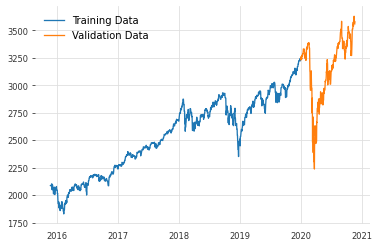

In [10]:
#training and testing data
plt.plot(train_data,label="Training Data",color='tab:blue')
plt.plot(test_data,label='Validation Data',color='tab:orange')
plt.legend()
plt.show()

# ARIMA / SARIMA

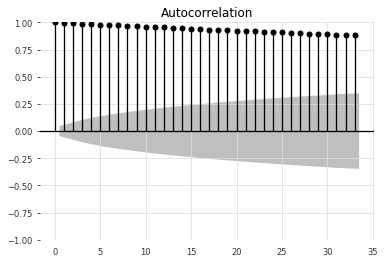

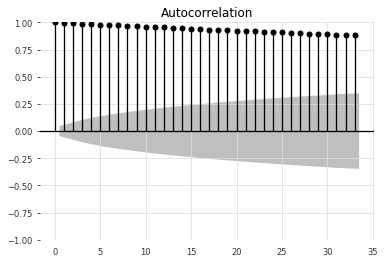

In [11]:
plot_acf(data.Close)

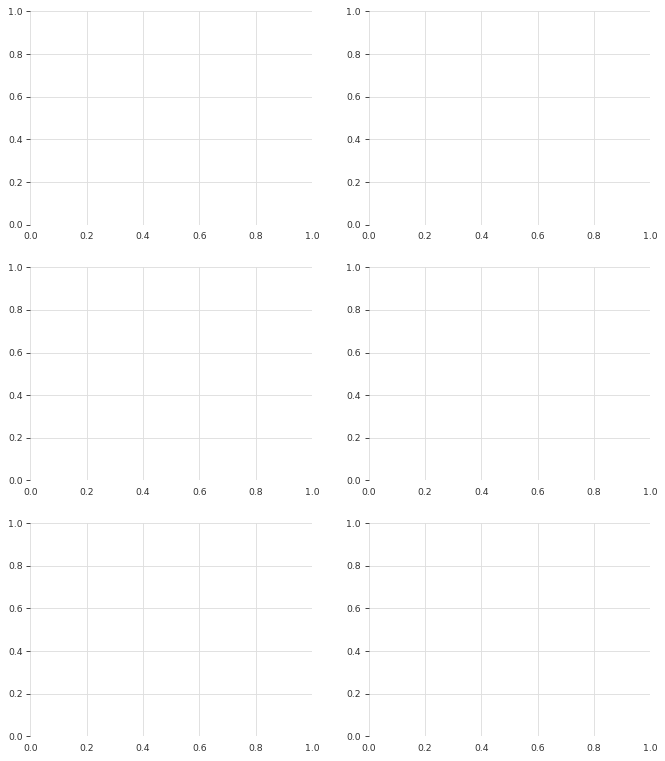

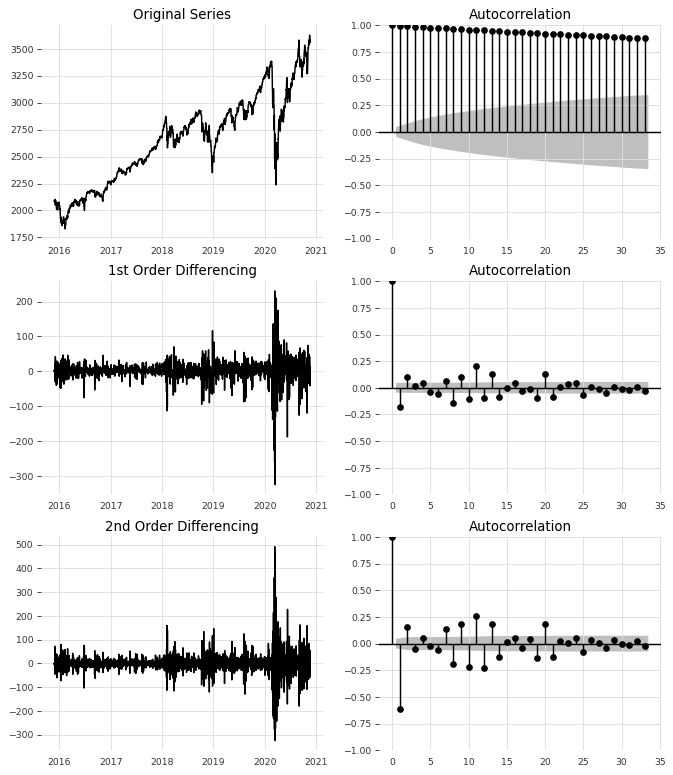

In [14]:
plt.rcParams.update({'figure.figsize':(10,12), 'figure.dpi':80})
fig, axes = plt.subplots(3, 2, sharex=False)

#Original

fig, axes = plt.subplots(3, 2, sharex=False)
axes[0, 0].plot(data.Close); axes[0, 0].set_title('Original Series')
plot_acf(data.Close, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(data.Close.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(data.Close.diff().dropna(), ax=axes[1, 1])
# 2nd Differencing
axes[2, 0].plot(data.Close.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(data.Close.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

C:\Users\jepp5\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


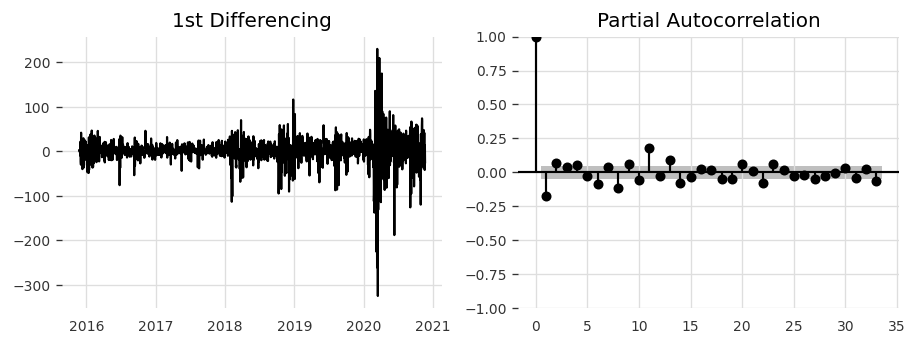

In [15]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(data.Close.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(data.Close.diff().dropna(), ax=axes[1])

plt.show()

In [21]:
adfuller(data.Close)
#Hence, non stationary

(-0.8703973870161126,
 0.7975646340657568,
 23,
 1801,
 {'1%': -3.4339861159726306,
  '5%': -2.863146142843122,
  '10%': -2.5676250581282964},
 16826.469381922303)

In [23]:
arima_model = auto_arima(train_data)
arima_model.order

(2, 1, 2)

In [24]:
pred = pd.DataFrame(arima_model.predict(n_periods=325),index=test_data.index)

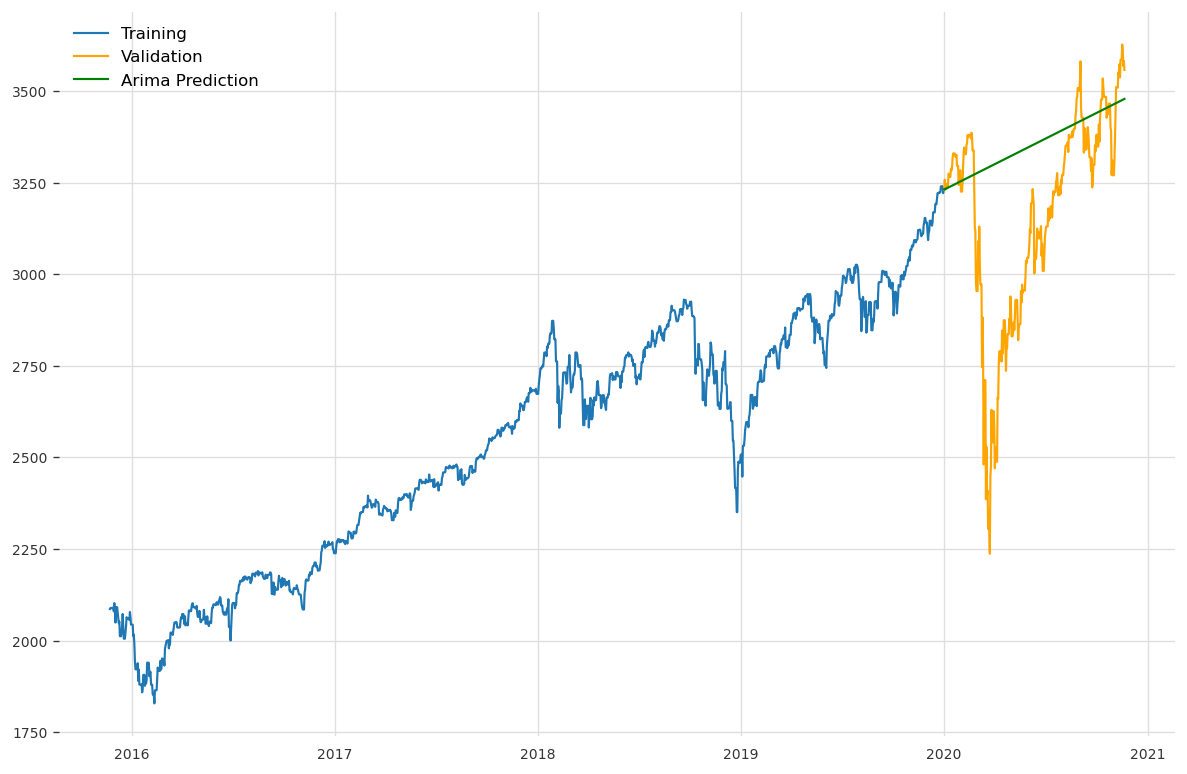

In [25]:
plt.figure(figsize=(12,8))
plt.plot(train_data,label="Training",color='tab:blue')
plt.plot(test_data,label='Validation',color='orange')
plt.plot(pred,label="Arima Prediction",color='green')
plt.legend(loc='upper left')
plt.show()

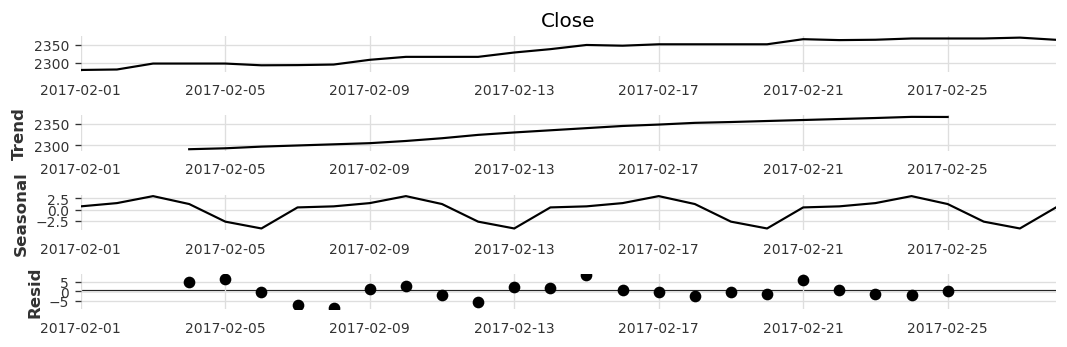

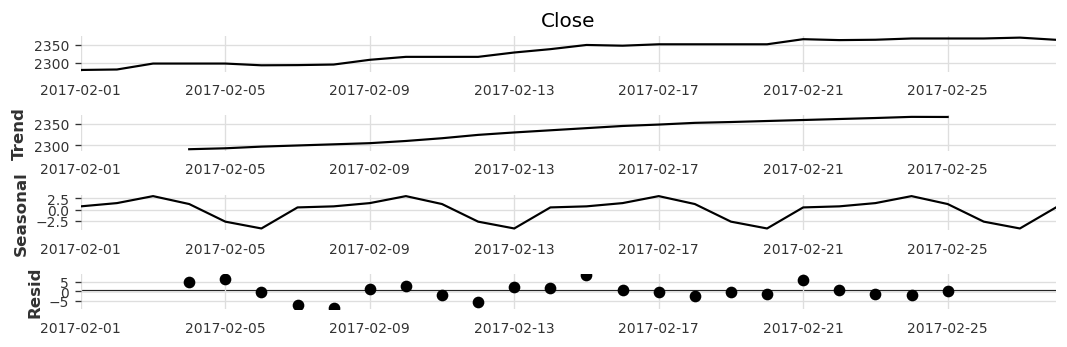

In [29]:
# TEST IF SARIMA IS BETTER (TESTING FOR SEASONALITY)
#using only 2017 feb to see seasonality
feb_data = data.Close['2017-02':'2017-02']
season = seasonal_decompose(feb_data)
season.plot()
#Seasonality seems to be weekly

Text(0.5, 1.0, 'Residuals')

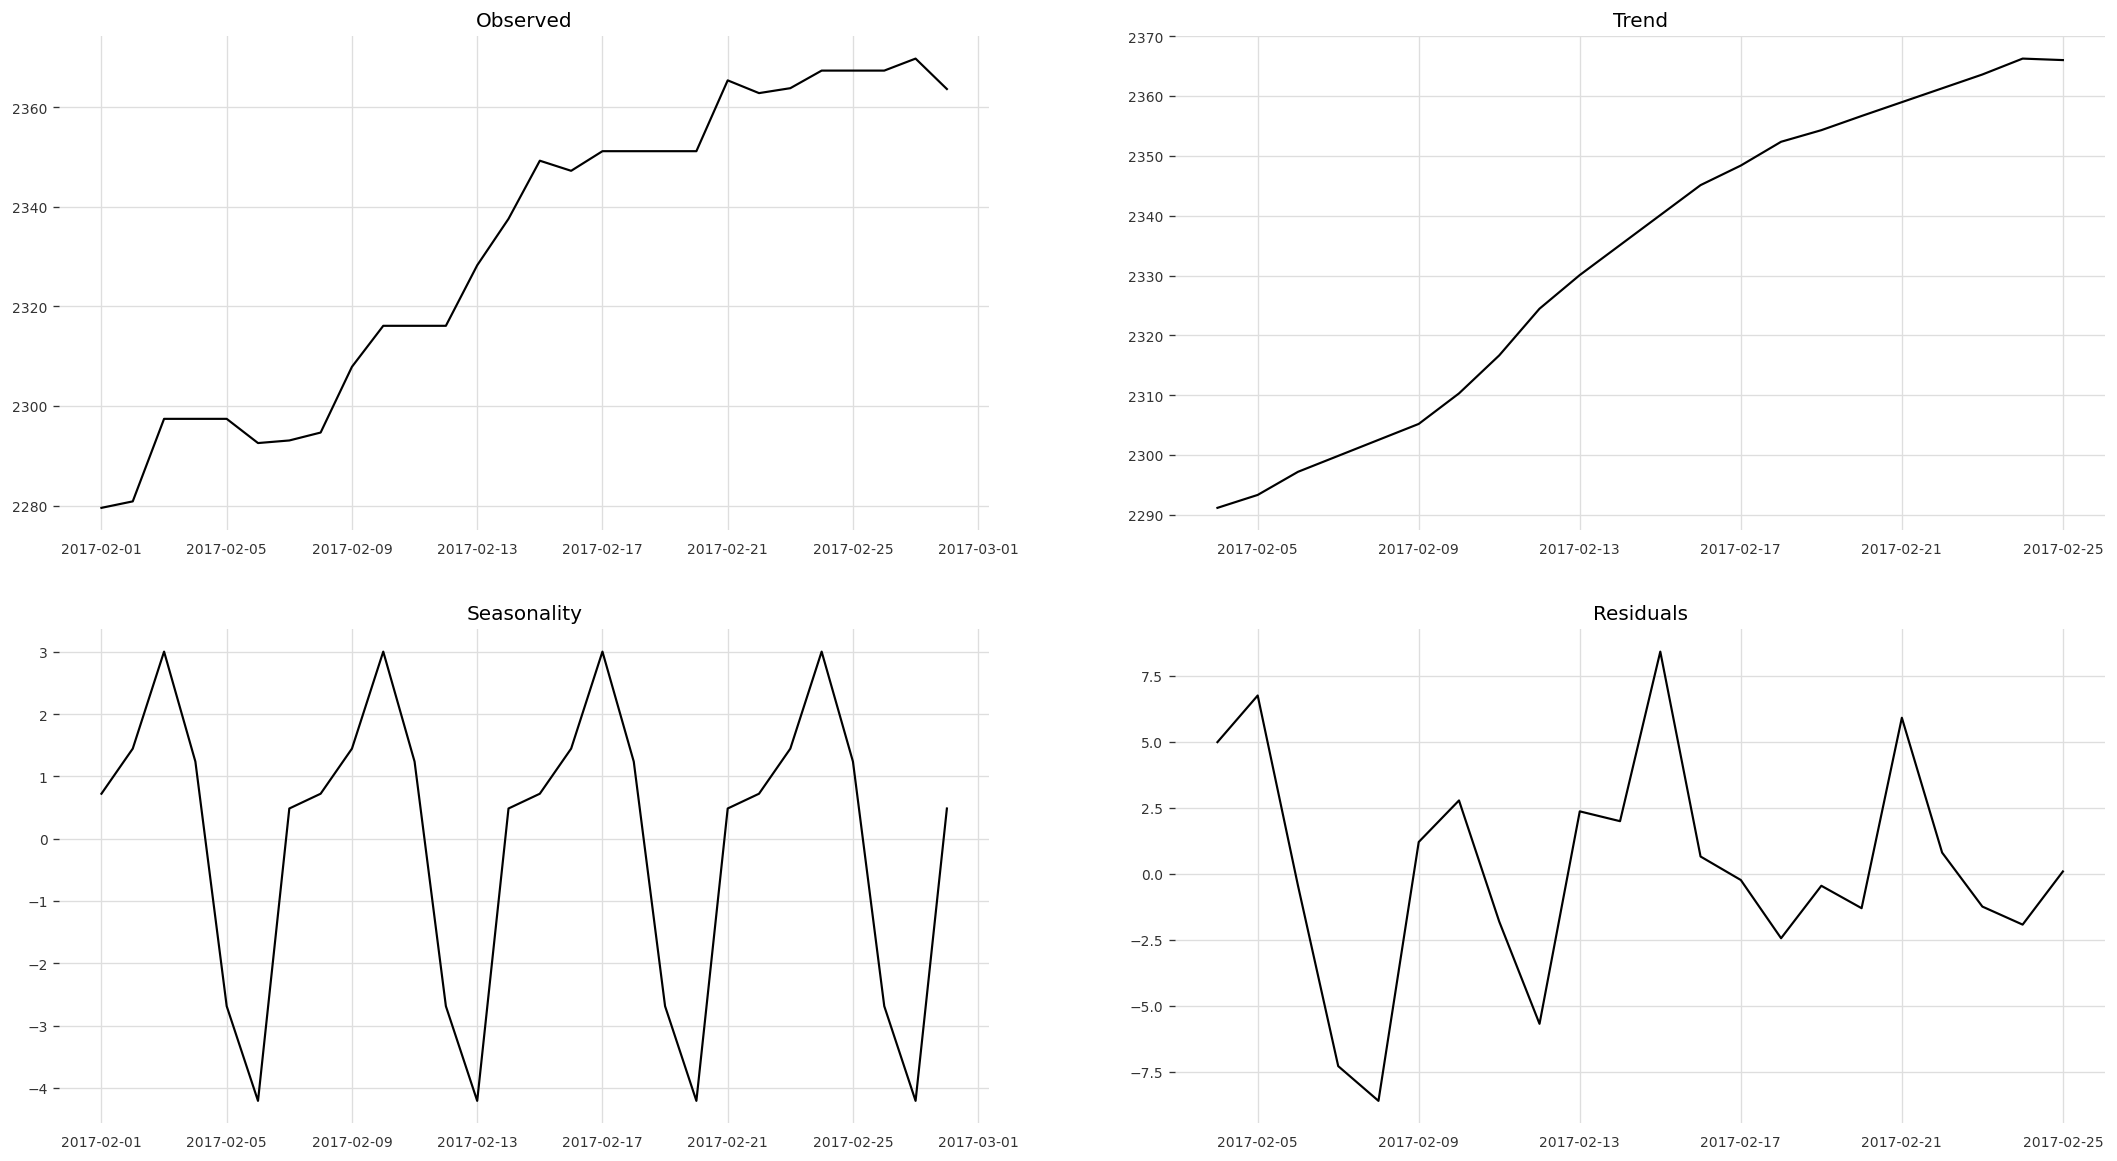

In [30]:
plt.rcParams.update({'figure.figsize':(22,12), 'figure.dpi':120})
fig, axes = plt.subplots(2, 2, sharex=False)
axes[0,0].plot(season.observed); axes[0,0].set_title('Observed')
axes[0,1].plot(season.trend); axes[0,1].set_title('Trend')
axes[1,0].plot(season.seasonal);axes[1,0].set_title('Seasonality')
axes[1,1].plot(season.resid);axes[1,1].set_title('Residuals')

#### Since there's clearly seasonality, SARIMA will likely outperform

<AxesSubplot:xlabel='Date'>

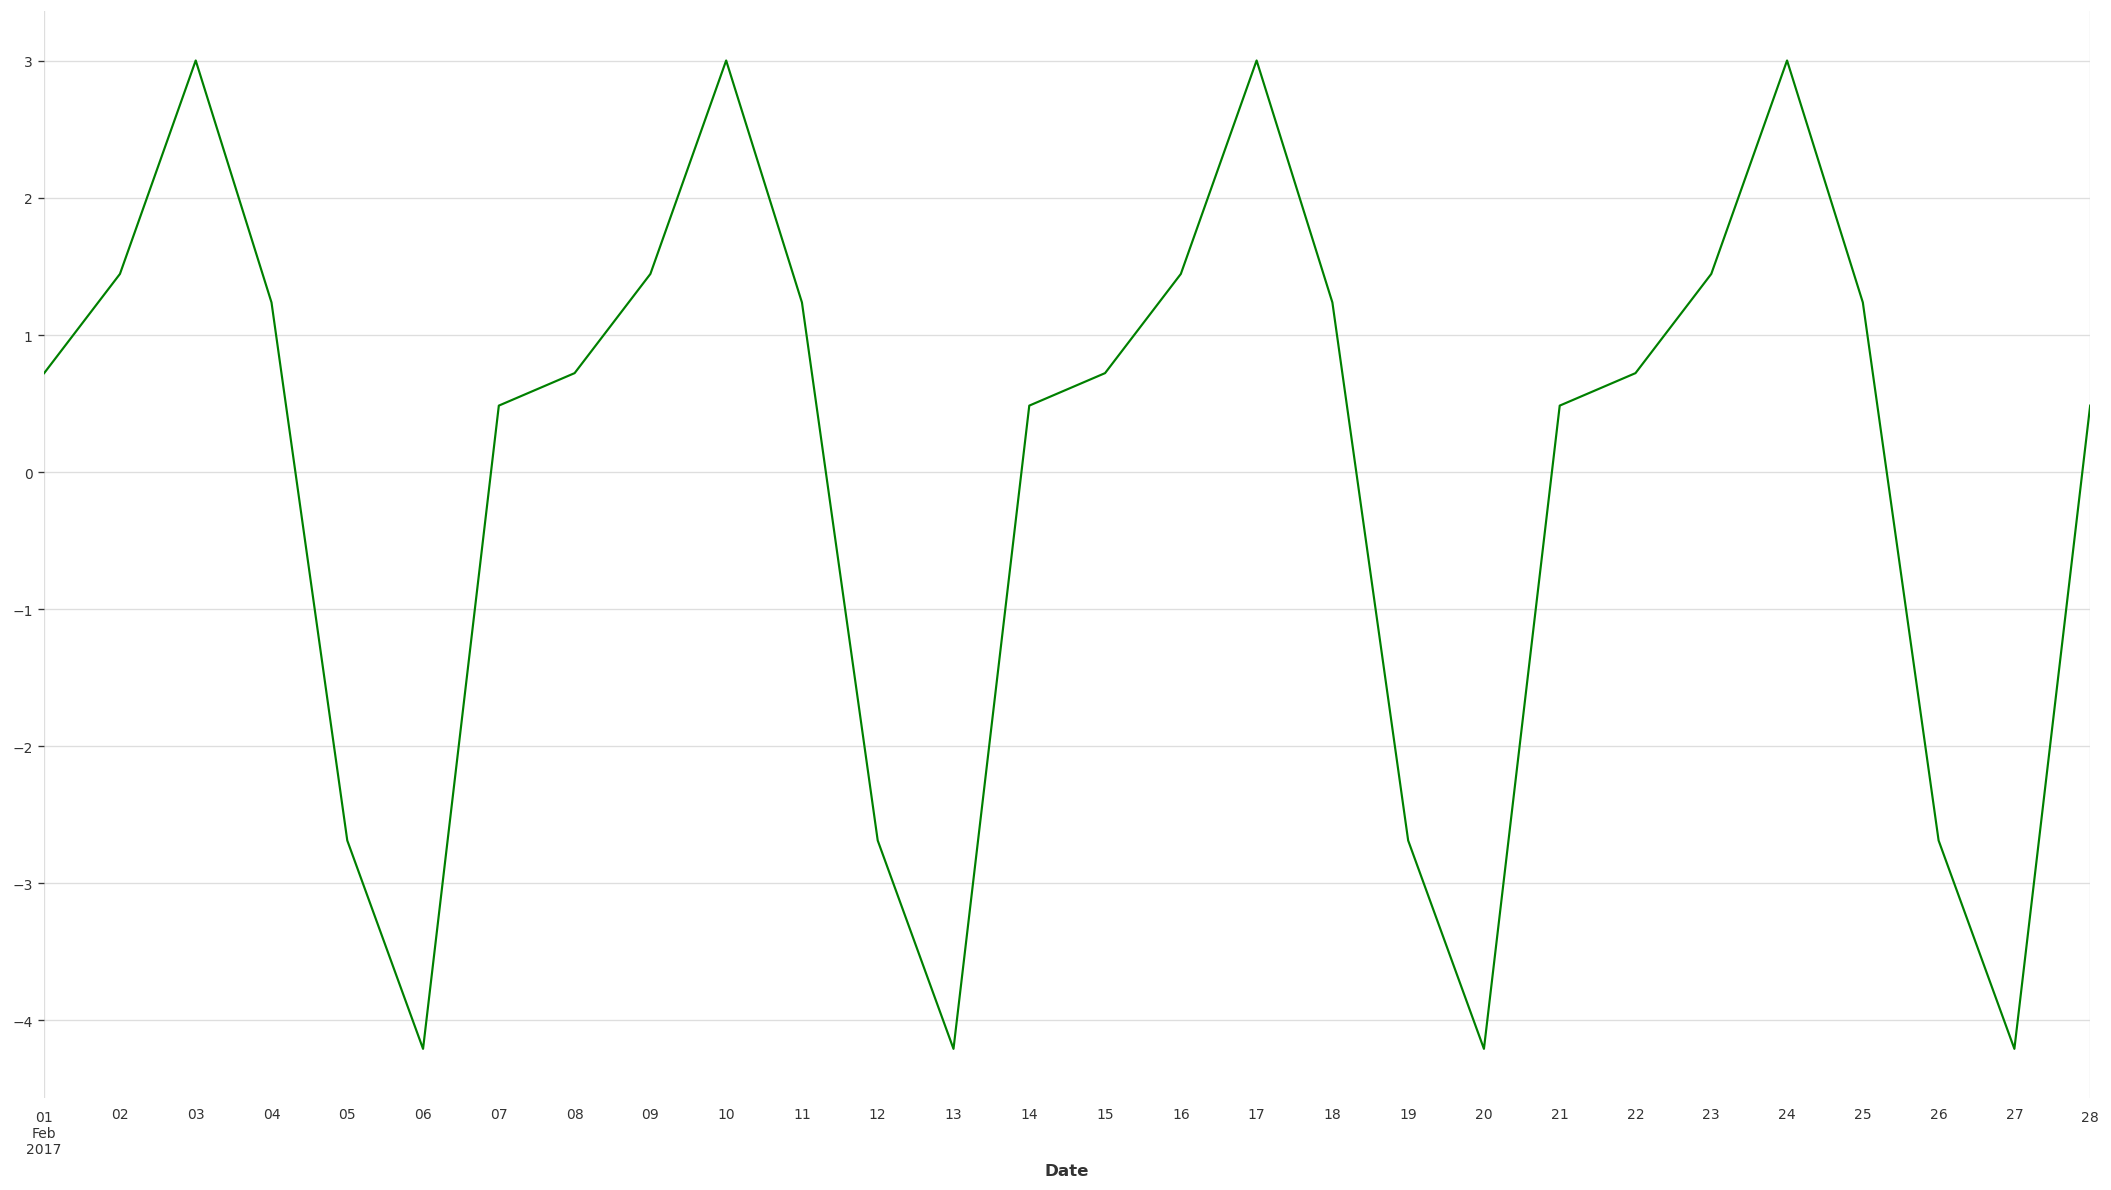

In [31]:
seasonality = season.seasonal
seasonality.plot(color='green')

In [118]:
p,d,q=arima_model.order
#timesteps per seasonlity = 7
#sarim = sm.tsa.statespace.SARIMAX(data.Close,order=arima_model.order,seasonal_order=(1,1,1,7))
sarim = sm.tsa.statespace.SARIMAX(train_data.to_frame(),order=arima_model.order,seasonal_order=(1,1,1,7))

#Still SARIMA (as opposed to SARIMAX) model, as exog parameters not passed 
sar_res = sarim.fit() 

C:\Users\jepp5\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\jepp5\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [166]:
sar_pred = sar_res.predict(start=len(train_data),end=len(train_data)+325)
sar_pred = sar_pred.reset_index()
sar_pred = sar_pred.rename(columns={"index":"Date"})
sar_pred = sar_pred.set_index('Date')
sar_pred

,predicted_mean
Date,
2020-01-01,3232.002944
2020-01-02,3231.227222
2020-01-03,3233.753810
2020-01-04,3233.023103
2020-01-05,3233.665143
...,...
2020-11-17,3482.999608
2020-11-18,3484.755707
2020-11-19,3485.589438


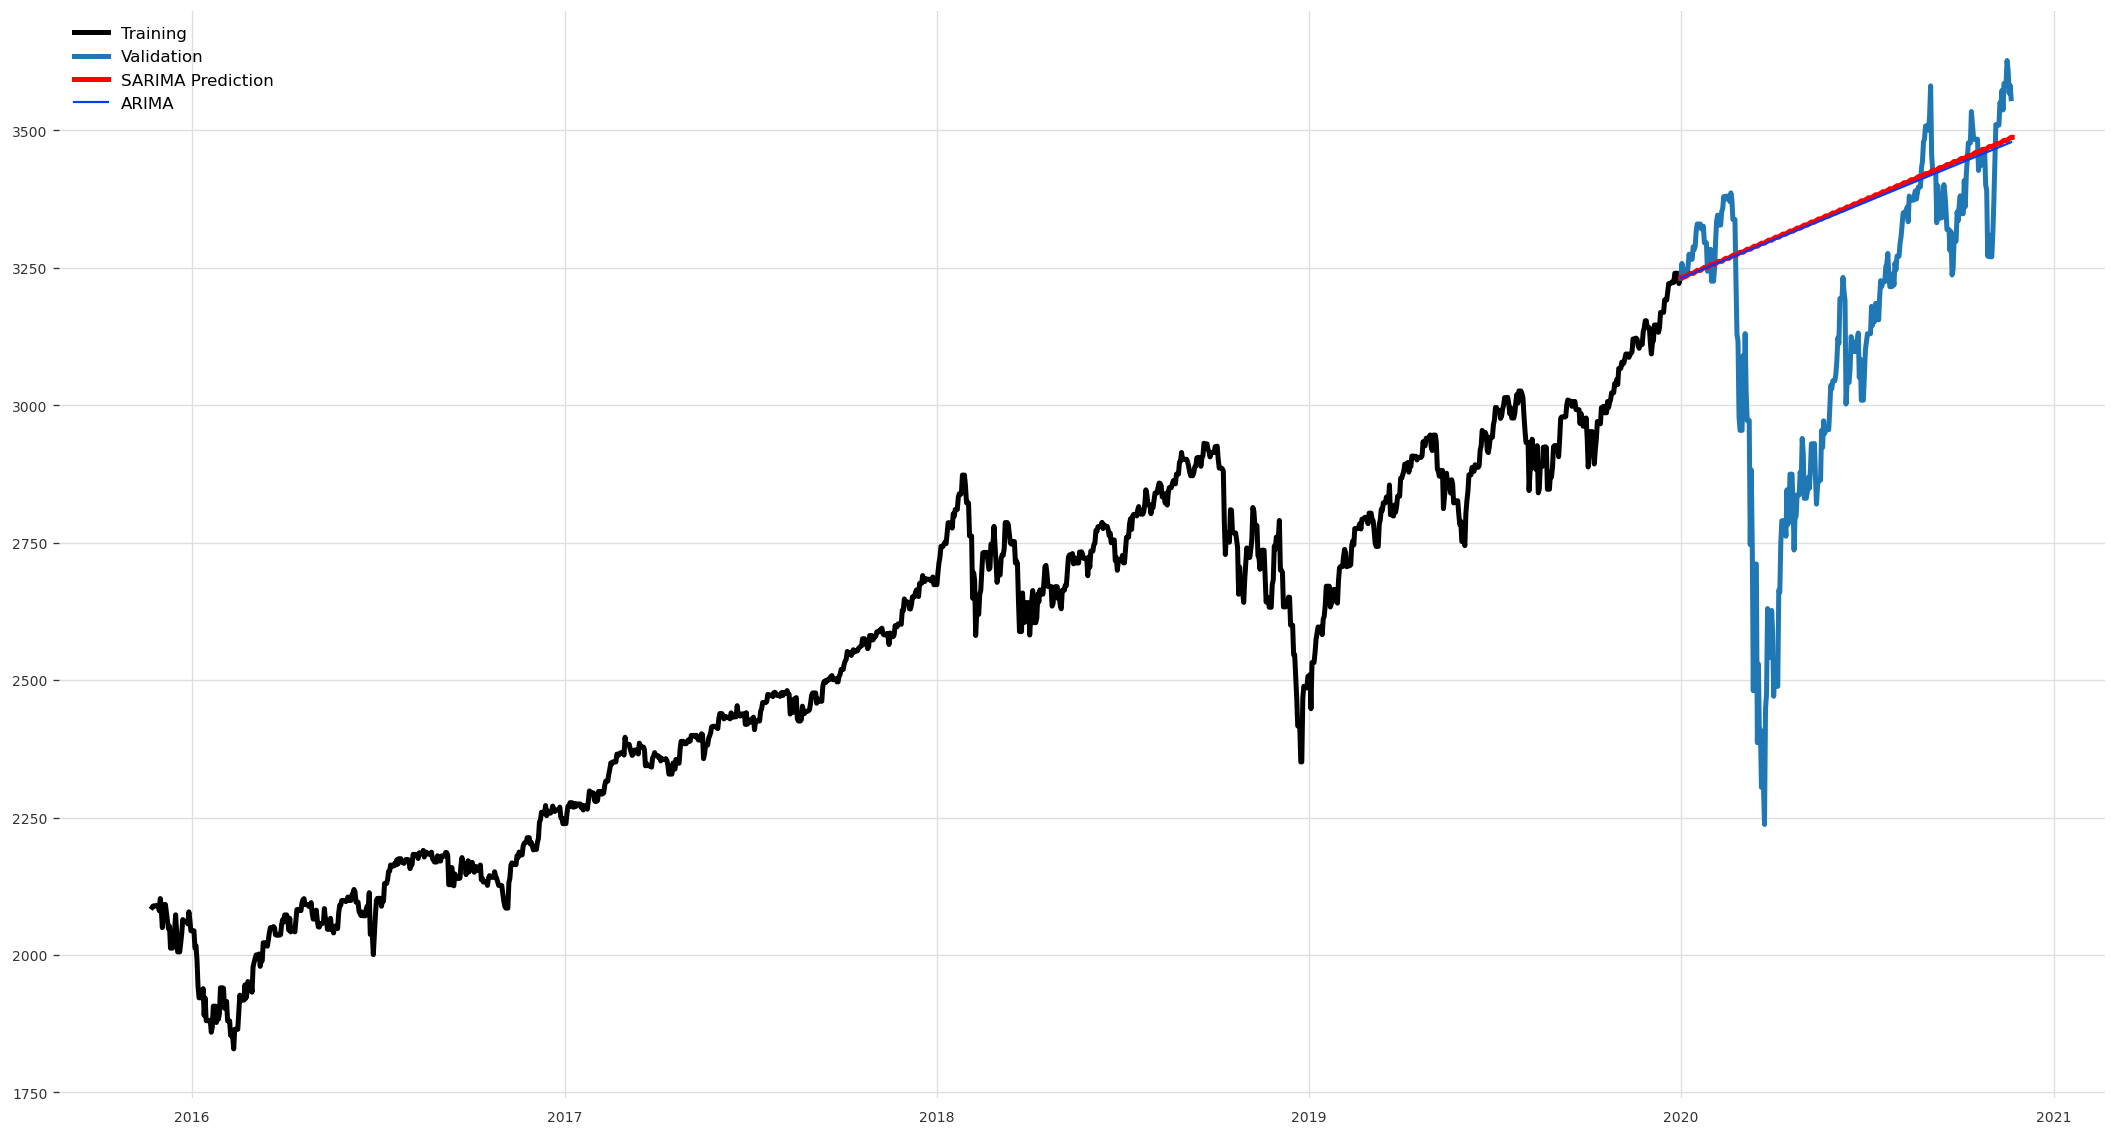

In [167]:
plt.plot(train_data,label='Training',lw=3)
plt.plot(test_data,label='Validation',color='tab:blue',lw=3)
plt.plot(sar_pred,label="SARIMA Prediction",color='red',lw=3)
plt.plot(pred,label="ARIMA")
plt.legend(loc='upper left')
plt.show()

In [62]:
#NEED MAPE

# LSTM

In [70]:
lstm_model = BlockRNNModel(model='LSTM',input_chunk_length=120,output_chunk_length=10,n_epochs=100)
#This model was tested with varying input lengths, and 120 proved to provide the best results
df = pd.read_csv('yahoo_stock.csv')

In [71]:
tsClose = TimeSeries.from_dataframe(df,'Date','Close')
tsOpen = TimeSeries.from_dataframe(df,'Date','Open')
tsHigh = TimeSeries.from_dataframe(df,'Date','High')
tsLow = TimeSeries.from_dataframe(df,'Date','Low')
tsAdjClose = TimeSeries.from_dataframe(df,'Date','Adj Close')

scClose,scOpen,scHigh,scLow,scAdjClose=Scaler(),Scaler(),Scaler(),Scaler(),Scaler()

sctsClose = scClose.fit_transform(tsClose)
sctsOpen = scOpen.fit_transform(tsOpen)
sctsHigh = scOpen.fit_transform(tsHigh)
sctsLow = scOpen.fit_transform(tsLow)
sctsAdjClose = scOpen.fit_transform(tsAdjClose)

split='2020-01-01'

trainclose,testclose = tsClose.split_before(pd.Timestamp(split))

ScTrainClose,ScTestClose = sctsClose.split_before(pd.Timestamp(split))
ScTrainOpen,ScTestOpen = sctsOpen.split_before(pd.Timestamp(split))
ScTrainHigh,ScTestHigh = sctsHigh.split_before(pd.Timestamp(split))
ScTrainLow,ScTestLow = sctsLow.split_before(pd.Timestamp(split))
ScTrainAdjClose,ScTestAdjClose = sctsAdjClose.split_before(pd.Timestamp(split))

In [192]:
lstm_model.fit(series=[ScTrainClose]) #1 variable
predictionLSTM1 = lstm_model.predict(n=len(ScTestClose), series=ScTrainClose)
predictionLSTM1 = scClose.inverse_transform(predictionLSTM1)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 2.8 K 
4 | fc            | Sequential       | 260   
---------------------------------------------------
3.1 K     Trainable params
0         Non-trainable params
3.1 K     Total params
0.012     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

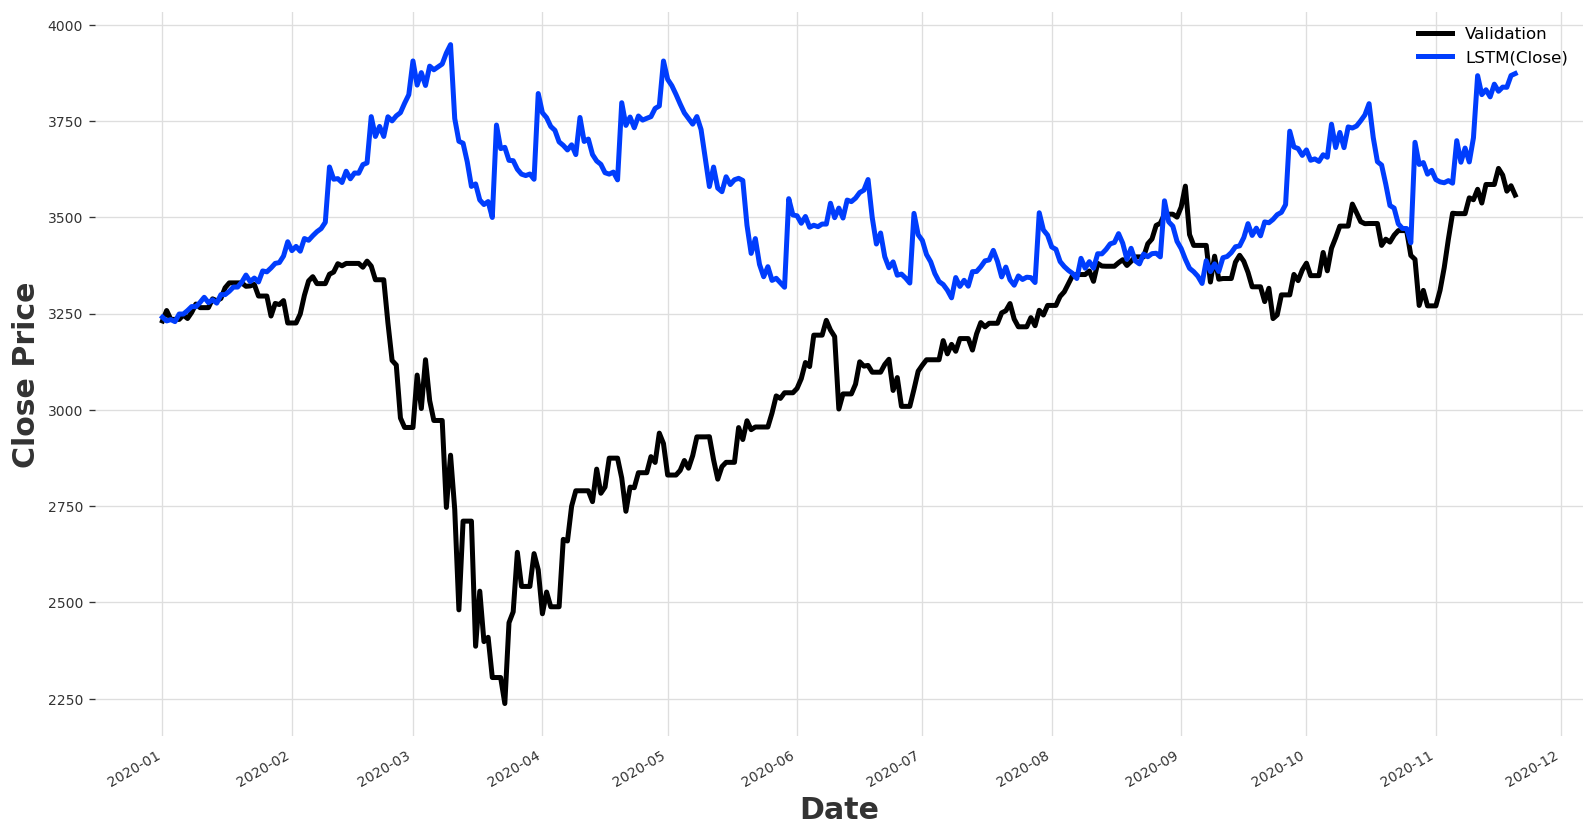

In [195]:

plt.figure(figsize=(16,8))
plt.title('LSTM Forecasting of Yahoo Stock')
testclose.plot(label='Validation',lw=3)
predictionLSTM1.plot(label='LSTM(Close)', lw=3)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.legend()
plt.show()

In [74]:
lstm_model.fit(series=[ScTrainClose,ScTrainOpen]) #2 variables
predictionLSTM = lstm_model.predict(n=len(ScTestClose), series=ScTrainClose)
predictionLSTM = scClose.inverse_transform(predictionLSTM)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 2.8 K 
4 | fc            | Sequential       | 260   
---------------------------------------------------
3.1 K     Trainable params
0         Non-trainable params
3.1 K     Total params
0.012     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

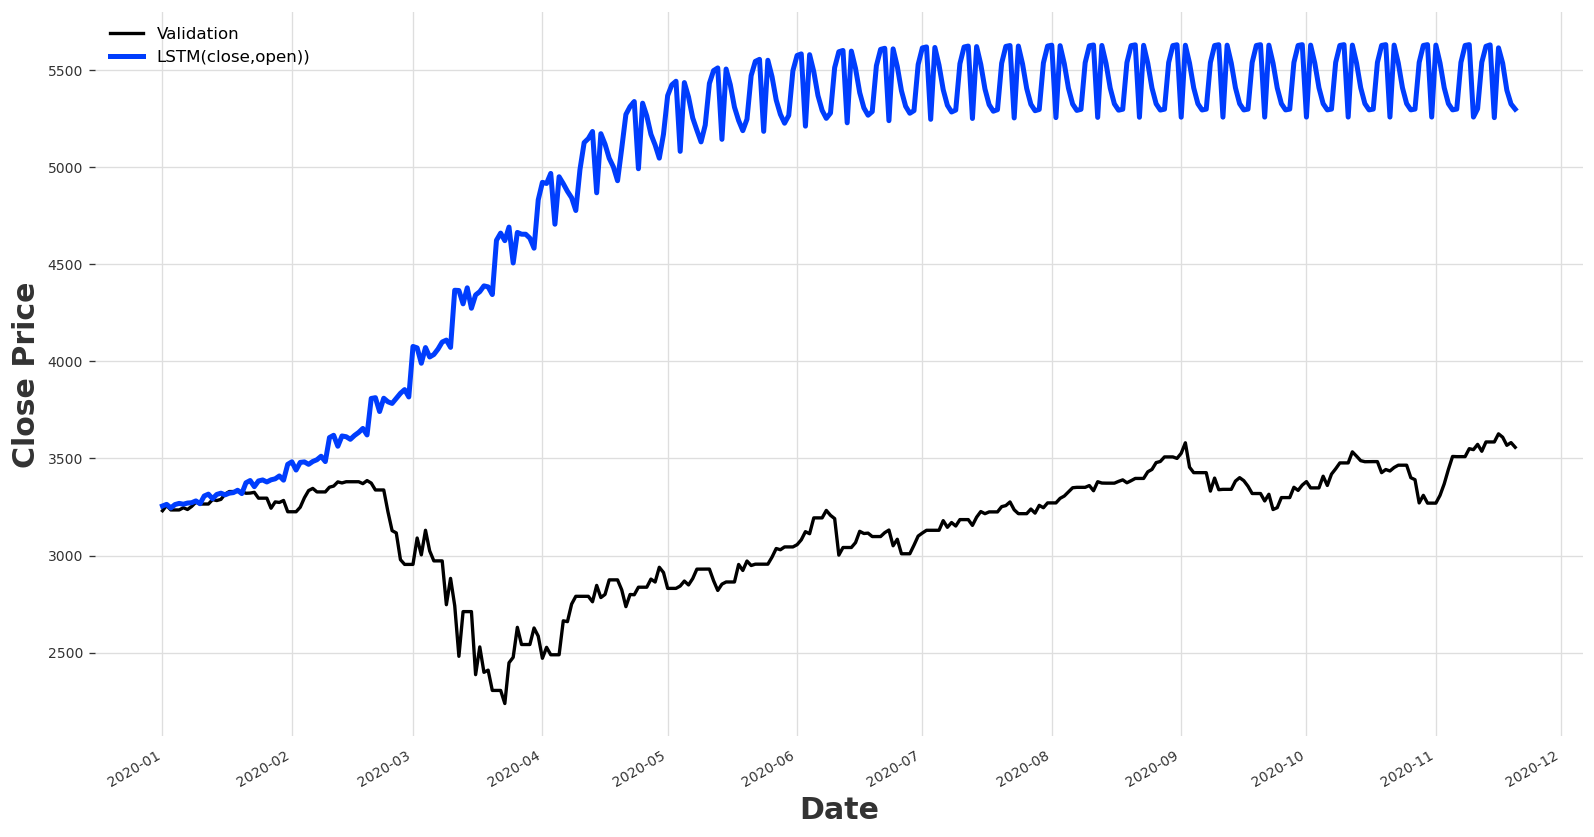

In [75]:
plt.figure(figsize=(16,8))
plt.title('LSTM Forecasting of Yahoo Stock')
testclose.plot(label='Validation')
predictionLSTM.plot(label='LSTM(close,open))', lw=3)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.legend()
plt.show()

In [77]:
lstm_model.fit(series=[ScTrainClose,ScTrainOpen,ScTrainHigh]) #3 variables
predictionLSTM3 = lstm_model.predict(n=len(ScTestClose), series=ScTrainClose)
predictionLSTM3 = scClose.inverse_transform(predictionLSTM3)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 2.8 K 
4 | fc            | Sequential       | 260   
---------------------------------------------------
3.1 K     Trainable params
0         Non-trainable params
3.1 K     Total params
0.012     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

In [82]:
lstm_model.fit(series=[ScTrainClose,ScTrainOpen,ScTrainHigh,ScTrainLow])#4 variables
predictionLSTM4 = lstm_model.predict(n=len(ScTestClose), series=ScTrainClose)
predictionLSTM4 = scClose.inverse_transform(predictionLSTM4)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 2.8 K 
4 | fc            | Sequential       | 260   
---------------------------------------------------
3.1 K     Trainable params
0         Non-trainable params
3.1 K     Total params
0.012     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 2.8 K 
4 | fc            | Sequential       | 260   
---------------------------------------------------
3.1 K     Trainable params
0         Non-trainable params
3.1 K     Total params
0.012     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

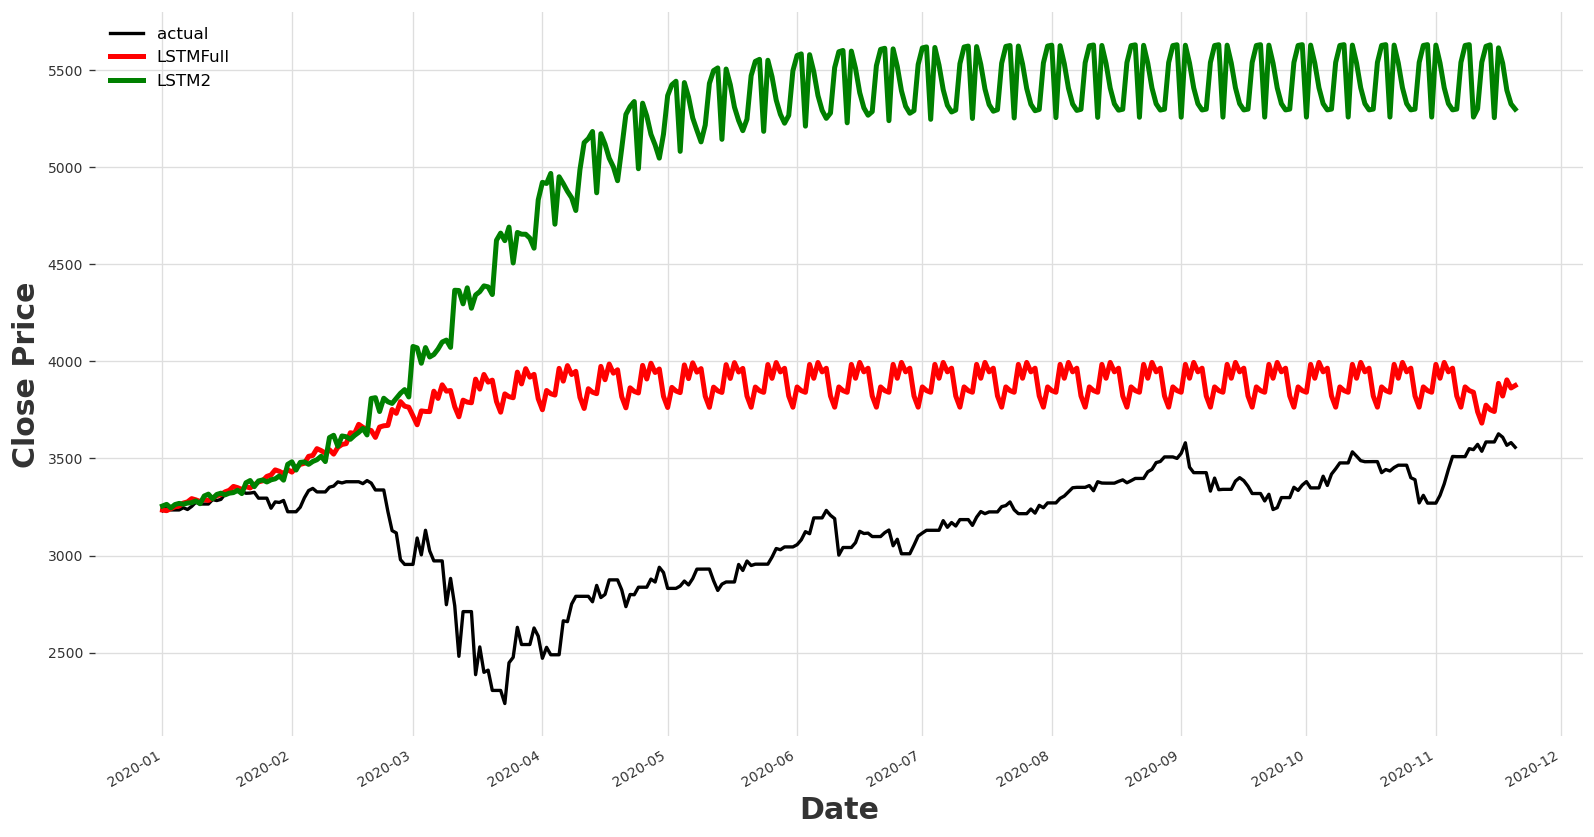

In [76]:
lstm_model.fit(series=[ScTrainClose,ScTrainOpen,ScTrainHigh,ScTrainLow,ScTrainAdjClose])
predictionLSTMFull = lstm_model.predict(n=len(ScTestClose), series=ScTrainClose)
predictionLSTMFull = scClose.inverse_transform(predictionLSTMFull)


plt.figure(figsize=(16,8))
plt.title('Yahoo Stock Price Prediction')
testclose.plot(label='actual',color='black')
predictionLSTMFull.plot(label='LSTMFull', lw=3,color='red')
predictionLSTM.plot(label='LSTM2',lw=3,color='green')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.legend()
plt.show()

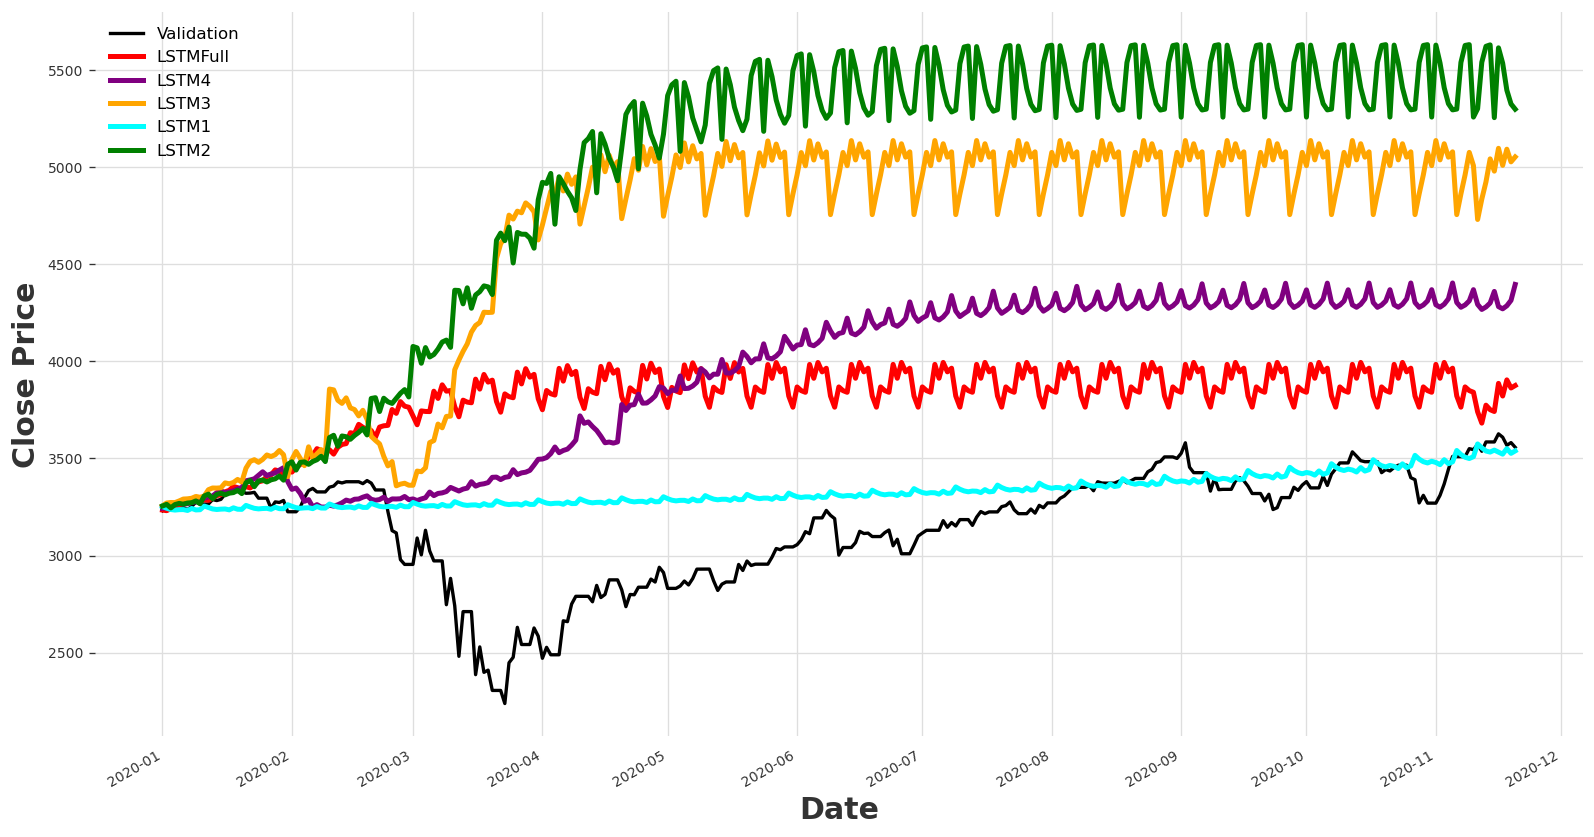

In [84]:
plt.figure(figsize=(16,8))
plt.title('Yahoo Stock Price Prediction')
testclose.plot(label='Validation',color='black')
predictionLSTMFull.plot(label='LSTMFull', lw=3,color='red')
predictionLSTM4.plot(label='LSTM4',lw=3,color='purple')
predictionLSTM3.plot(label='LSTM3',lw=3,color='orange')
predictionLSTM1.plot(label='LSTM1',lw=3,color='cyan') #Only close value
predictionLSTM.plot(label='LSTM2',lw=3,color='green') #close + open
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.legend()
plt.show()

# PROPHET

In [78]:
proph_model = Prophet(seasonality_mode='multiplicative',yearly_seasonality=False,weekly_seasonality=True,daily_seasonality=False)
proph_model

Prophet(add_seasonalities=None, country_holidays=None, suppress_stdout_stderror=True, add_encoders=None, cap=None, floor=None, seasonality_mode=multiplicative, yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=False)

In [79]:
proph_model.fit(ScTrainClose)
proph_pred = proph_model.predict(n=len(ScTestClose),num_samples=200)

15:41:28 - cmdstanpy - INFO - Chain [1] start processing
15:41:29 - cmdstanpy - INFO - Chain [1] done processing


In [80]:
prop_pred=scClose.inverse_transform(proph_pred)

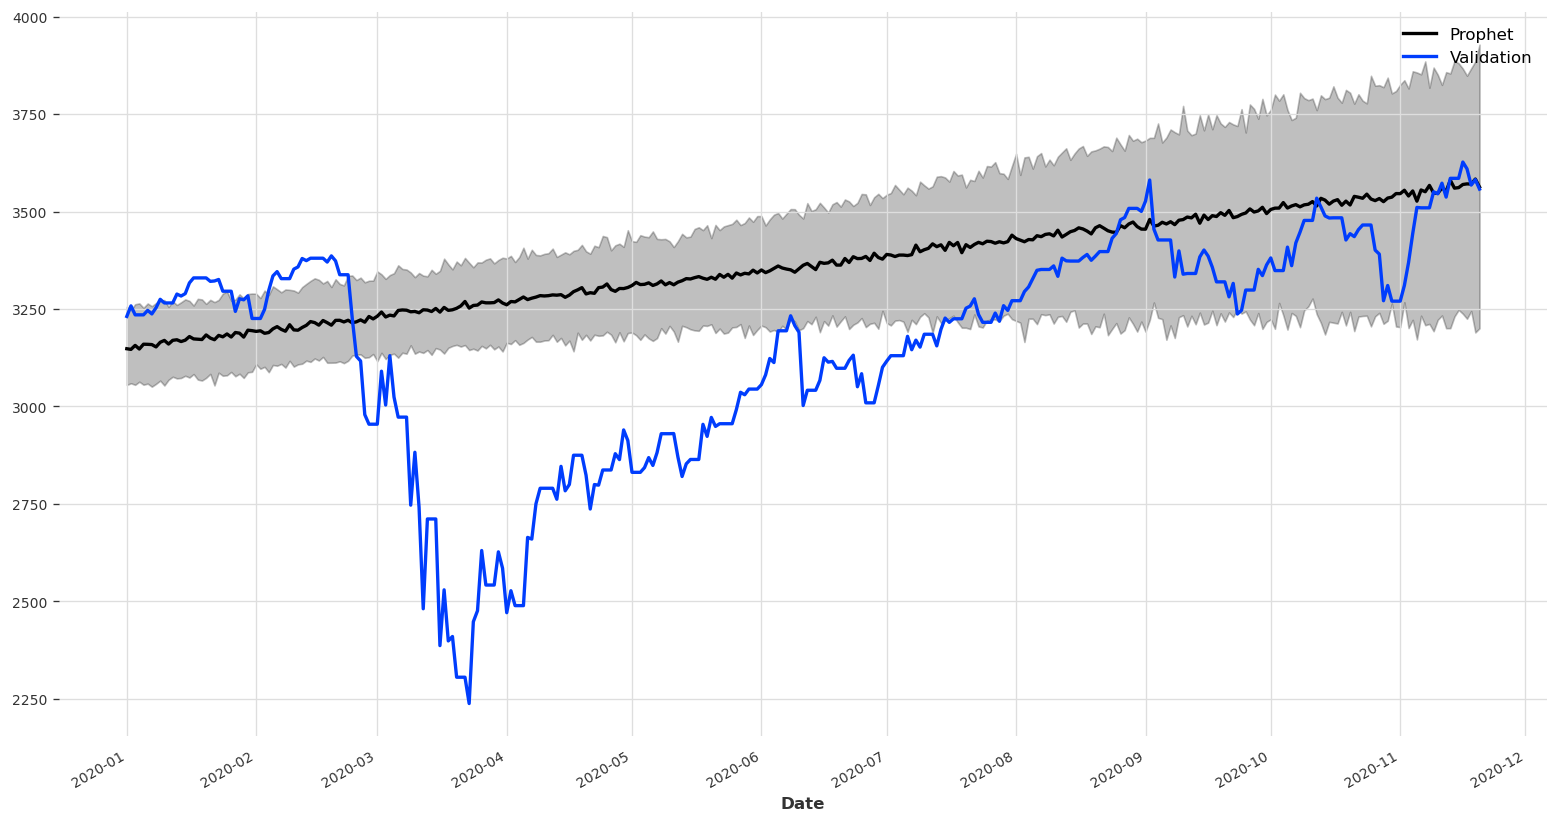

In [81]:
plt.figure(figsize=(16,8))
plt.title('prophet')
prop_pred.plot(label='Prophet')
testclose.plot(label='Validation')
plt.legend()
plt.show()

In [197]:
print("mape for LSTM1:", mape(testclose, predictionLSTM1))
print("mape for LSTM2:", mape(testclose, predictionLSTM))
print("mape for LSTM3:", mape(testclose, predictionLSTM3))
print("mape for LSTM4:", mape(testclose, predictionLSTM4))
print("mape for LSTMFull:", mape(testclose, predictionLSTMFull))
print("mape for SARIMA",mape(testclose,TimeSeries.from_dataframe(sar_pred)))
print("mape for prophet:",mape(testclose,prop_pred))

mape for LSTM1: 13.46326739575083
mape for LSTM2: 57.44083514690388
mape for LSTM3: 48.11688319267073
mape for LSTM4: 25.129105262545654
mape for LSTMFull: 21.614436069336787
mape for SARIMA 8.122712192593822
mape for prophet: 8.458896289561325
